<a href="https://colab.research.google.com/github/napatt2/PINN-SBM/blob/main/Inverse_friction_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.9 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



# Import the Dataset
We use only first 1,000 data points of $u, v,$ and $\theta$ spanning from time 0 to 100.

In [ ]:
raw = pd.read_csv('sbm_inv.csv')
raw = raw[0:1000]
observe_t = raw['t']
u_ext = raw['u']
v_ext = raw['v']
theta_ext = raw['theta']

# Formulation of the Problem
The system of ODEs can be written as follows:
\begin{gather*}
        \frac{d\tilde{u}}{d\tilde{t}} = \tilde{v} \\
        \frac{d\tilde{v}}{d\tilde{t}} = \kappa(v_o \tilde{t} - \tilde{u}) - \alpha(f_o + a \log \tilde{v} + b \log \tilde{\theta}) \\
        \frac{d\tilde{\theta}}{d\tilde{t}} = 1 - \tilde{v}\tilde{\theta}
    \end{gather*}
Here, parameters $\kappa$ and $\alpha$ are defined as 0.5 and 1.0, respectively. However, we do not include measurements of $\theta$ in the training process as it is not available in-situ. Additionally, the form of the rate-and-state friction is simplified to a function of time, under the assumption that we have no prior knowledge of the friction formula. Thus, the loss functions can be written as follows:
\begin{align*}
MSE &= MSE_R + MSE_m \\
MSE_R &= \frac{1}{N_R} \sum_{i=1}^{N_R} \left| \left( \frac{du}{dt} \right) (t_i, \varphi) - v(t_i, \varphi) \right|^2 \\
&\quad + \frac{1}{N_R} \sum_{i=1}^{N_R} \left| \frac{dv}{dt}(t_i, \varphi) - \kappa(v_0 t_i - u(t_i, \varphi)) + \tau(t_i) \right|^2 \\
MSE_m &= \frac{1}{N_m} \sum_{i=1}^{N_m} \left| u(t_i, \varphi) - u^*(t_i) \right|^2 + \frac{1}{N_m} \sum_{i=1}^{N_m} \left| v(t_i, \varphi) - v^*(t_i) \right|^2 \\
\end{align*}


In [ ]:
kappa = 0.5
v0 = 1.0

## Define ODE system
Three output neurons are `u`, `v`, and `tau`, respectively. We take the derivative for each of the outputs with respect to time `x`.

In [ ]:
def ode_system(x, y):
    u, v, tau = y[:, 0:1], y[:, 1:2], y[:, 2:3]
    du_t = dde.grad.jacobian(y, x, i=0)
    dv_t = dde.grad.jacobian(y, x, i=1)

    return [du_t - tf.clip_by_value(v,0,13),
            dv_t - kappa * (v0 * x - u) + tau]

## Define Geometry and Measurement Loss
We specify time domain in variable `geom`. Additionally, we assign the measurements of $u$ and $v$ as data loss via variable `observe_y0` and `observe_y1`.

In [ ]:
geom = dde.geometry.TimeDomain(0, 100)

observe_t = observe_t.values.reshape((-1, 1))
u_ext = u_ext.values.reshape((-1, 1))
v_ext = v_ext.values.reshape((-1, 1))
theta_ext = theta_ext.values.reshape((-1, 1))

observe_y0 = dde.icbc.PointSetBC(observe_t, u_ext, component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, v_ext, component=1)


# Compile and Train Model
The geometry, equations, measurements, number of collocation points in the domain and on the boundary, achors for the invese problem, and number of test data points are defined in `data`.

In [ ]:
dde.config.set_random_seed(20)
data = dde.data.PDE(
    geom,
    ode_system,
    [observe_y0, observe_y1],
    num_domain=2000,
    num_boundary=1000,
    anchors=observe_t,
    num_test=1000,
)

The network consists of 1 input neuron of time, 3 hidden layers of 100 neurons, and 3 output neurons of $u, v,$ and $\tau$. The model uses TanH activation function with Glorot uniform initialization. We run for 100,000 iterations using Adam optimization

Compiling model...
Building feed-forward neural network...
'build' took 0.052085 s

'compile' took 0.444876 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.56e-01, 8.14e+02, 3.14e+03, 8.34e-01]    [1.56e-01, 8.14e+02, 3.14e+03, 8.34e-01]    []  
1000      [5.43e-02, 4.15e+00, 8.71e+01, 5.36e-01]    [5.37e-02, 4.14e+00, 8.71e+01, 5.36e-01]    []  
2000      [3.47e-02, 3.24e-01, 7.99e+00, 4.78e-01]    [3.39e-02, 3.22e-01, 7.99e+00, 4.78e-01]    []  
3000      [3.20e-02, 1.20e-01, 1.92e+00, 4.00e-01]    [3.13e-02, 1.20e-01, 1.92e+00, 4.00e-01]    []  
4000      [1.84e-02, 8.02e-02, 9.67e-01, 2.79e-01]    [1.82e-02, 8.00e-02, 9.67e-01, 2.79e-01]    []  
5000      [1.16e-02, 6.50e-02, 7.34e-01, 2.19e-01]    [1.14e-02, 6.46e-02, 7.34e-01, 2.19e-01]    []  
6000      [1.99e-02, 6.60e-02, 5.48e-01, 1.99e-01]    [1.98e-02, 6.57e-02, 5.48e-01, 1.99e-01]    []  
7000      [7.47e-03, 7.65e-02, 1.09e-01

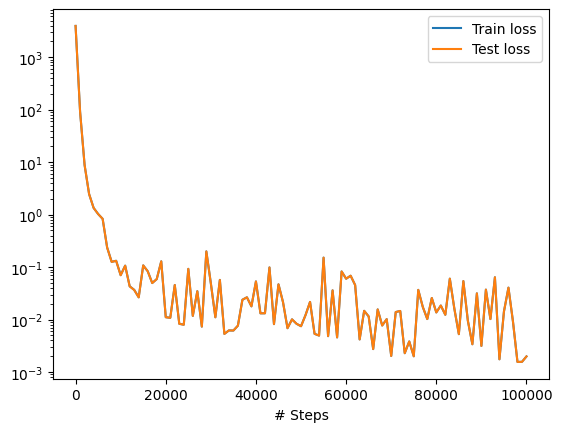

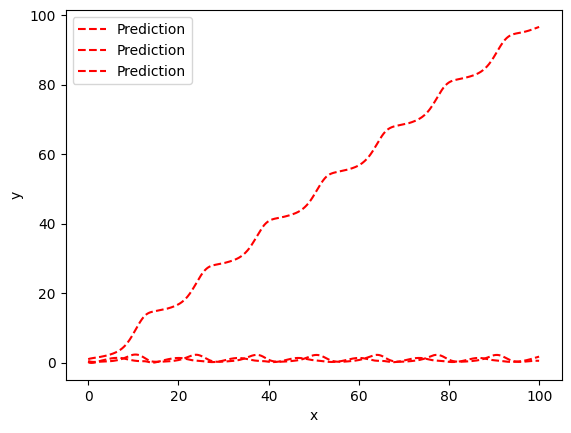

In [ ]:
net = dde.nn.FNN([1] + [100] * 3 + [3], "tanh", "Glorot uniform")

model = dde.Model(data, net)
model.compile("adam", lr=0.001)
checker = dde.callbacks.ModelCheckpoint(
    "model/model.ckpt", save_better_only=True, period=1)
losshistory, train_state = model.train(iterations=100000, callbacks=[checker])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Prediction and Plotting

In [ ]:
t = np.linspace(0,100,2000).reshape(-1,1)
yhat = model.predict(observe_t)
uhat, vhat, tauhat = yhat[:, 0:1], yhat[:, 1:2], yhat[:, 2:3]

Text(0, 0.5, 'u')

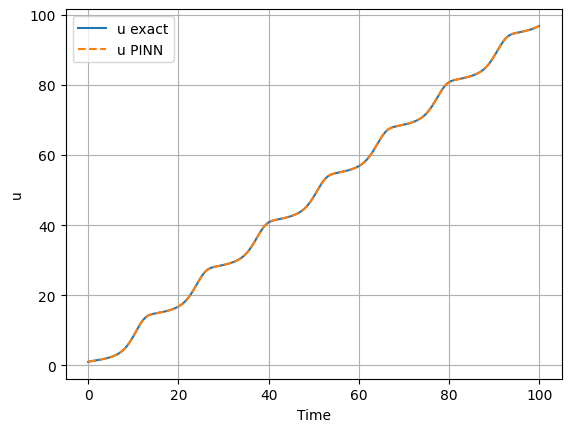

In [ ]:
plt.figure()
plt.plot(observe_t, u_ext, "-", label="u exact")
plt.plot(observe_t, uhat, "--", label="u PINN")
plt.legend()
plt.grid()
plt.xlabel('Time')
plt.ylabel('u')

Text(0, 0.5, 'v')

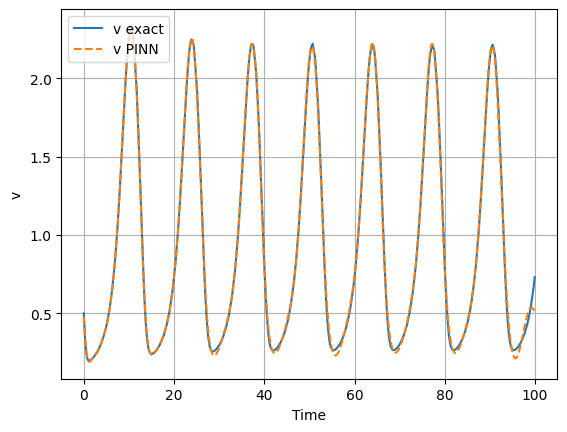

In [ ]:
plt.figure()
plt.plot(observe_t, v_ext, "-", label="v exact")
plt.plot(observe_t, vhat, "--", label="v PINN")
plt.legend(loc = 'upper left')
plt.grid()
plt.xlabel('Time')
plt.ylabel('v')

In [ ]:
alpha = 4
kappa = 0.5
v0 = 1
f0 = 0.2
a = 0.2
b = 0.3

In [ ]:
tau = alpha * (f0 + a * np.log(v_ext) + b * np.log(theta_ext))

Text(0, 0.5, 'Friction')

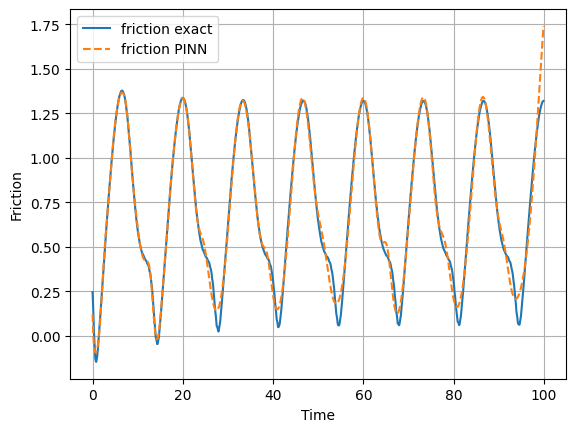

In [ ]:
plt.figure()
plt.plot(observe_t, tau, "-", label="friction exact")
plt.plot(observe_t, tauhat, "--", label="friction PINN")
plt.legend(loc = 'upper left')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Friction')

In [ ]:
l2_u = np.sqrt(np.sum((u_ext - df['pred_u'])**2)/np.sum(u_ext**2))
l2_v = np.sqrt(np.sum((v_ext - df['pred_v'])**2)/np.sum(u_ext**2))
l2_tau = np.sqrt(np.sum((tau - df['pred_t'])**2)/np.sum(tau**2))

In [ ]:
l2_u, l2_v, l2_tau

(0.0004087801758618251, 0.00044098378584410034, 0.06906065555395573)

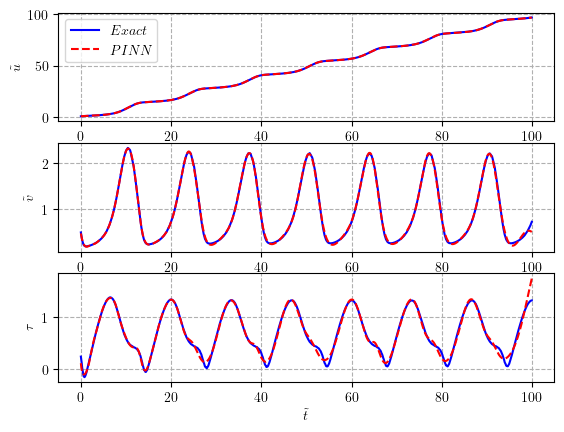

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.rcParams['text.usetex'] = True # TeX rendering
fig, axs = plt.subplots(3, 1)
plt.figure()
axs[0].plot(observe_t, u_ext, "-", color = 'blue', label=r"$Exact$")
axs[0].plot(observe_t, uhat, "--", color = 'red', label=r"$PINN$")
axs[1].plot(observe_t, v_ext, "-", color = 'blue')
axs[1].plot(observe_t, vhat, "--", color = 'red')
axs[2].plot(observe_t, tau, "-", color = 'blue')
axs[2].plot(observe_t, tauhat, "--", color = 'red')

axs[0].set(ylabel=r'$\tilde{u}$')
axs[1].set(ylabel=r'$\tilde{v}$')
axs[2].set(xlabel=r'$\tilde{t}$', ylabel=r'$\tau$')

axs[0].legend(loc="upper left")
axs[0].grid(linestyle = 'dashed')
axs[1].grid(linestyle = 'dashed')
axs[2].grid(linestyle = 'dashed')